# Leonard Kramer Problem
This notebook is for the general audience. Elementary python and math are the only prerequisits. If you have any suggestion, doubt pr proposal, feel free to contact me on [her.mesrib.eiro] (at) gmail . com

<img src="red-wine.jpg" alt="Two glasses of wine" height="160" width="240">
## Deep learning application to process engineering problems
The Leonard Kramer problem is a toy problem related to the fields of process fault identification and detection in the field of chemical processengineering. Proposed by [Leonard & Kramer, 1991](http://ieeexplore.ieee.org/document/75576/), it brings ease of visualization and a comprehensive parametric generation of patterns which closely approximates real life examples of process faults.

### Process industries
The chemical process industry is responsible to transform raw material into comercial products. Some examples of transformations are:

|Raw Material|Product|
|---|---|
|Oil|Gasoline,Diesel,Plastics|
|Starch,Yeast,Water|Beer,Wine,Spirits|
|Ore|Metals|
|Sulfur,Water|Sulfuric Acid|
|Fat,Soda|Soap|
|Vegetables|Sugar|
|Leaves,Fruits|Essencial oils|

In order to achieve these transformations in large scale and in a continuous/semi-continuous fashion, several industrial level equipment must be arranged in a complex manner. Some examples of industrial equipment are storage tanks, chemical reactors, distillation columns, heaters, coolers, furnaces, pressure vessels and so on. <br><br>
Now, in order yield a constant quality product, the industrial staff's main goal is to ensure that all conditions in all of the equipment remain constant, regardless of the external influences on the process. For the sake of generality, these conditions are called <b>process variables</b>. Some example of process variables are temperature, pressure, flow rate, density, concentration etc.<br><br>
Since most of the current industrial process plants contain dozens of equipment, maintaining all process variables in harmony takes a huge amount of effort. Thanks to computation, most of these processes are already highly automated, so fewer human supervision and intervention in the process is required. However, two jobs remain mostly dependant on human intervention, the one to design such processes and the one to diagnose failure on the several process components. This notebook covers the second type of problem.

### Fault detection and diagnosys
Suppose you own a wine factory. Your customers expect the greatest of quality standards on your product. They also expect that the next bottle they buy has the same taste than the last one they consumed. However, your process is succeptible to various factors such as the farm you buy your grapes from, ambient temperature and humidity, tap water temperature etc. You consulted an expert and he told you that the main process variables you should be concerned are the wine's sweetness and tanins concentration. So, if you notice any change in those two <b>process variables</b> during the production batch, you should readily intervene.<br><br>
The first problem arises when you realize that it is very difficult/expensive to measure these process variables in real time. So you hire another expert (tipically an engineer), to help you with this task. This expert tells you that, instead of spending thousands to read these variables on-line, you can spend a few dollars on equipment to read the temperature and alcohol content (usually by reading the wine density) on your fermentation drum. Moreover, you can easily buy some control equipment that will read the temperature for you and actuate some heater/cooler in case you have any problems with tmperature and add some sugar/water in case you have any problem with alcohol concentration. Problem solved, you are happy, the expert is happy, the customer is happy and your bank account is happy, right? Not so fast.<br><br>
Equipment break, thermometers break, valves break, electronic circuits crash, workers sleep and so on and so forth. When problems like these arise, it's usually a human being who is responsible to diagnose the root causes. Now, for a wine factory, maybe it's an easy task for anyone with enough experience in the process. However, for complex operations like oil fractioning into liquefied gas, nafta, gasoline, diesel, light oil, heavy oil and asphalt, there are so many things that can cause any given problem that the human effort to diagnose it may take days. And, as Uncle Sam says, time is money! Wouldn it be nice to have an artificial intelligence to make such diagnosis for us? Yes, and this is the topic of this notebook. Below we treat the wine factory problem because it is easy and intuitive to deal with only two variables. However, the same reasoning we apply here can be expanded to deal with more complex process industries, such as the above mentioned oil refinery.

### Our wine factory
Remember that, in the wine factory, the most important quality indicators were the wine's <b>sweetness</b> and <b>tanins</b>? Remember also that, instead of monitoring those two quantities, we chose to monitor the fermentation drum's <b>temperature</b> and <b>alcohol concentration</b>? If something goes wrong with the operation, how do we relate the former <b>process variables</b> with the latter? Well, we will make a simplistic assumption that they relate almost linearly:<br><br>
$$Temperature = 25^{\circ}C + \alpha_1 *Sweetness + \alpha_2 *Tanins \quad \textrm{(1)}$$
$$Alc. Concentration = 10\% + \alpha_3 *Sweetness - \alpha_4 * Tanins \quad \textrm{(2)}$$
<br><br>
Where $\alpha_i$ are correlational parameters. Now, in order to facilitate our problem visualization, we can subtract all four process variables by their baseline values (previously estabilished by our enologist and our engineer) so that the value is zero when operating in normal conditions and nonzero otherwise, and divide them by a factor $\beta_i$ to ignore the effect of their scale.
<br><br>
$$T = (Temperature - 25^{\circ}C)/\beta_1$$
$$C = (Alc. Concentration - 10\%)/\beta_2$$
$$S = (Sweetness - 3g/L)/\beta_3$$
$$tan = (Tanin - 500mg/L)/\beta_4$$
<br><br>
How $\alpha_i$ relates to $\beta_j$ is not in the scope of this work. Now, we can rewrite (1) and (2) in their dimensionless scaled form to:<br><br>
$$T=S+tan$$
$$C=S-tan$$
<br><br>
We have now defined our problem. As long as $T$ and $C$ remains equal to zero, our process is working fine.

### Generating faults
We assume that at any given moment, $S$ and $tan$ behave under a random gaussian distribution $\mathcal{N}(0,0.25)$. Since requiring them to be specifically $0$ is practically infeasible, we may establish a tolerance of $+- 0.05$.
<br><br>
$$Normal: \left| S \right|<0.05, \left| tan \right|<0.05$$
<br><br>
So, whatever faults occur in the process will most likely make the wine have a positive or negative displacement on it's sweetness and alcoholic content beyond this treshold. Since many different faults may occur, we will focus on two generic types of faults: <br><br>
<br><br>
$$Type 1: \left| S \right|>0.05, \left| tan \right|<0.05$$
$$Type 2: \left| S \right|<0.05, \left| tan \right|>0.05$$
<br><br>
We now are able to generate a chart of operating conditions in the $(S,tan)$ space.

In [1]:
import numpy as np
from keras.models import Model, Sequential,load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
np.set_printoptions(precision=6,suppress=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
#Global parameters
epocas = 3000 # Global variable controlling the number of epochs for all ML models
n = 150 # Number of Patterns to be parametrically generated (multiple of 3)
sd1=.25 # Standard Deviation for the generation ofprocess variables
sd2 = 0.015 # Standard Deviation for the intrumental noise
tr=.05 # Normal operation treshold

In [3]:
# Operating conditions (OC)
def cond(p1,p2,flag): 
    if flag==1: # Normal OC (acceptable p1 and p2)
        return(abs(p1)<tr and abs(p2)<tr)
    elif flag==2: #Type 1 error (acceptable p2, unacceptable p1)
        return(abs(p1)>tr and abs(p2)<tr)
    elif flag==3: #Type 2 error (acceptable p1, unacceptable p2)
        return(abs(p1)<tr and abs(p2)>tr)

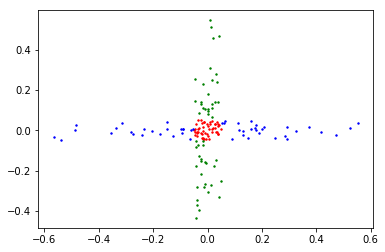

In [4]:
patterns = np.zeros([n,5]) # Parametric matrix to generate database
count = 0
i=[0,int(n/3),int(2*n/3),int(n)] # Equally sized OC indexes. Normal: [0:n/3], T1: [n/3:2n/3], T2: [2n:3,n]
np.random.seed(1234)
for pos,idx in enumerate(i):
    while count < idx:
        # Random (p1,p2)
        p1 = np.random.normal(0,sd1)
        p2 = np.random.normal(0,sd1)
        # Verify process state
        if cond(p1,p2,pos):
            # Record operation condition
            patterns[count,0] = p1
            patterns[count,1] = p2
            patterns[count,pos+1] = 1
            count += 1
# Plot OCs
plt.scatter(patterns[i[0]:i[1],0],patterns[i[0]:i[1],1],c='r',s=2)
plt.scatter(patterns[i[1]:i[2],0],patterns[i[1]:i[2],1],c='b',s=2)
plt.scatter(patterns[i[2]:i[3],0],patterns[i[2]:i[3],1],c='g',s=2)
plt.show()

We said above that the relationship between $(S,tan)$ and $(T,C)$ was "almost" linear. It is not exacly linear because of the absolute value operator on the state variables, due to the +- 0.05 tresholld. So, a simplified visualization of the operating conditions on the $(S,tan)$ space, considering the absolute value tresholds is:

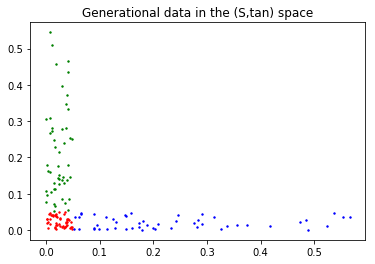

In [5]:
plt.scatter(np.absolute(patterns[i[0]:i[1],0]),np.absolute(patterns[i[0]:i[1],1]),c='r',s=2)
plt.scatter(np.absolute(patterns[i[1]:i[2],0]),np.absolute(patterns[i[1]:i[2],1]),c='b',s=2)
plt.scatter(np.absolute(patterns[i[2]:i[3],0]),np.absolute(patterns[i[2]:i[3],1]),c='g',s=2)
plt.title("Generational data in the (S,tan) space")
plt.show()

Applyind the previously mentioned transformation on the data, we can view our process fault diagnosis chart in the $(T,C)$ space.

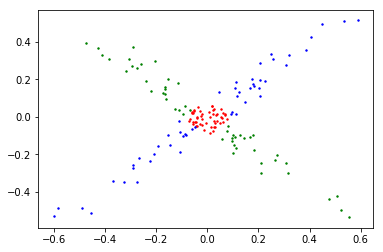

In [6]:
x = np.zeros([n,5])
for idi in range(len(patterns)):
    x[idi,0] = patterns[idi,0] + patterns[idi,1]
    x[idi,1] = patterns[idi,0] - patterns[idi,1]
    x[idi,2:] = patterns[idi,2:]
plt.scatter(x[i[0]:i[1],0],x[i[0]:i[1],1],c='r',s=2)
plt.scatter(x[i[1]:i[2],0],x[i[1]:i[2],1],c='b',s=2)
plt.scatter(x[i[2]:i[3],0],x[i[2]:i[3],1],c='g',s=2)
plt.show()

These are the data patterns we will feed to our networks, since, in real problems, this is what we can measure. The data in the $(S,tan)$ space will remain hidden from the machine learning, since these are also hidden to any human operator. In techincal terms, what we are doing here is loosely defined as sequentially implementing a soft sensor on the process, followed by a fault detection routine.

In [7]:
data = x[:,0:2]
target = x[:,2:]

### Applying ANNs
According to Bengio et al. 2016, one of the modern interpretations of deep learning is that they are a composition of functions. One can interpret any given layer of a neural network as applying a nonlinear transformation $\mathbb{R}^n \rightarrow \mathbb{R}^m$ of the type:
<br><br>
$$Y = f(X)$$
<br><br>
where $X \in \mathbb{R}^n$, $f,Y \in \mathbb{R}^m$ and $f$ is to be found by adaptive learning. So, when you implement many layers of a neural network, you are actually making a composite function $f_1(f_2(f_3(...f_k(x))))$. Also, the composition capacity of ANNs represents an exponential increase in capacity as compared with a wider, single hidden layer neural network. By analogy, in the classification problem, it's like you are folding the space in many different forms consecutively untill you can properly separate the space in identifiable regions. This is what we will try to accomplish here.

---

## Neural Architecture
Using this interpretation, we have a hint on how to draw our architecture.
* First, the scatterplot in the $(T,C)$ space has five different regions, four diagonal and one central. So, in the first layer, we will add five neurons in the hope that this layer can capture this nuance (there is no theoretical basis for this choice whatsoever). 
* Second, these five regions render three different error types. So, we add three neurons in the second layer. (Again, no theoretical basis for this assumption).
* Third, we add the last layer with two neurons to visualize the classification task in the last layer space (LLS).

What we are trying to do here is to hardwire in the architecture the identification of five "X" shaped OC regions to three "L" shaped OC regions and make it draw them clearly on a cartesian plot. Ideally, it shoulld recover something similar to the <i>generational data in the (S,tan) space</i>.

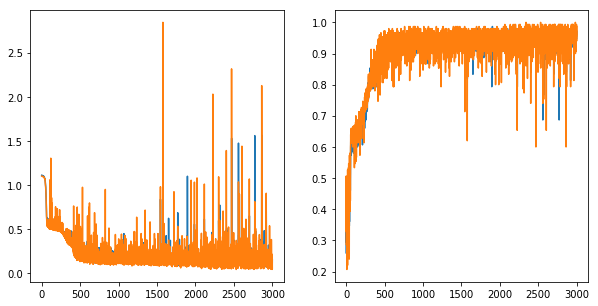

Error:  0.0415606148293
Accuracy:  1.0
Confusion C_(i,j) -> i: predicted, j: actual. 
[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
Wall time: 14min 43s


In [8]:
%%time
np.random.seed(2379)
model = Sequential() # Fully connected ANN
# Adding the layers to design the 5-3-2-2-3 architecture
# Hyperblic tangent activation functions in all layers
model.add(Dense(units=5, activation='tanh', input_dim=2,name="l4"))
model.add(Dense(units=3, activation='tanh',name="l3"))
model.add(Dense(units=2, activation='tanh',name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
# Defining ANN optimizer, error and pperformance
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
# Early stopping. Saves the best performance model
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
# Saving performance curves and training the model
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
# PLotting training performance
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
# Writing performance indicators and confusion matrix on the screen
model = load_model('bestfit.hdf5')
evaluation = model.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)

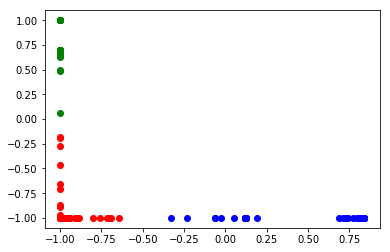

In [9]:
# Retrieving the outputs in the last layer space (LLS)
inter = Model(inputs=model.input, outputs=model.get_layer('l1').output)
interout = inter.predict(data)
# Plotting  the ANN outputs in the LLS
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(interout[i[0]:i[1],1],interout[i[0]:i[1],0],'ro',
         interout[i[1]:i[2],1],interout[i[1]:i[2],0],'bo',
         interout[i[2]:i[3],1],interout[i[2]:i[3],0],'go')
plt.show()

Now, go back in the notebook and look at the "Generational data in the (S,tan) space" plot. So, our strategy worked!

By hardwiring our previous knowlege of the problem into architectural cues, we were able to make the ML model learn, by itself and from the data only, to find the concealed root causes for the wine quality failures. In other words, the deep learning model learned how to rotate, squash and fold the "X" shaped (T,C) plot into something <b>similar</b> to the "L" shaped root cause plot. This complex series of transformations, which simplified the classification task, was only possible through a sequence of nonlinear transformations in the form of a fully connected deep learning architecture.

We proceed to anwer if a shallow NN can achieve tha same goals. To level the playing field we must compare it with another architecture with the same number of parameters. Our previous architecture had 15 neurons and 41 synaptic bridges, which is the approximate amount of parameters of a 9-2-3 architecture, with 15 neurons and 42 synapses.

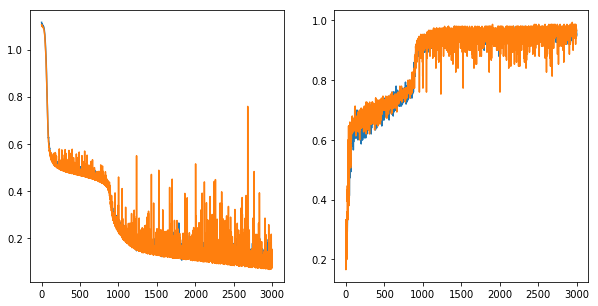

Error:  0.066657243669
Accuracy:  0.98
Confusion C_(i,j) -> i: predicted, j: actual. 
[[50  0  0]
 [ 2 48  0]
 [ 1  0 49]]


In [10]:
# Same comments as before apply
np.random.seed(2379)
model = Sequential()
model.add(Dense(units=9, activation='tanh', input_dim=2,name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
history = model.fit(data, target, epochs=epocas, batch_size=1,verbose=0,callbacks=[callbacks],validation_data=(data,target))
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
model = load_model('bestfit.hdf5')
evaluation = model.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)


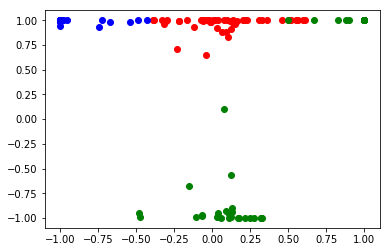

In [11]:
inter = Model(inputs=model.input, outputs=model.get_layer('l1').output)
interout = inter.predict(data)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(interout[i[0]:i[1],1],interout[i[0]:i[1],0],'ro',
         interout[i[1]:i[2],1],interout[i[1]:i[2],0],'bo',
         interout[i[2]:i[3],1],interout[i[2]:i[3],0],'go')
plt.show()

This archiitecture renders a nice 2D plot, with visually clear separable regions. However, it did not give us a plot that seemingly approaches the original generational data in the $(S,tan)$ space. The classification performance is also a little worst than the 5-3-2-2-3 architecture.

So, by fixing the amount of parameters, this shows that the correct topology of a neural network is of paramount importance for classification tasks. The literature confirms this observation, by stating that by increasing the depht of your network, you exponentially gain more expressive power than you would by simply increasing the breadth of a shallow network.

### Winery IRL
In real life, any measurement is subject to random noise. To account for this phenomenon, we will introduce stochastic noise to $S$ and $tan$, by adding $\nu_1$ and $\nu_2$, with a gaussian distribution of  $\mathcal{N}(0,0.015)$ and see how it plays out in the $(T,C)$ space.

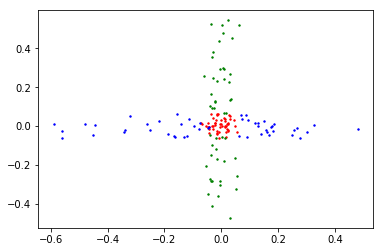

In [12]:
count = 0
np.random.seed(1234)
for pos,idx in enumerate(i):
    while count < idx:
        p1 = np.random.normal(0,sd1)
        p2 = np.random.normal(0,sd1)
        if cond(p1,p2,pos):
            patterns[count,0] = p1 + np.random.normal(0,sd2) # sweetness plus noise
            patterns[count,1] = p2 + np.random.normal(0,sd2) # tannins plus noise
            patterns[count,pos+1] = 1
            count += 1
plt.scatter(patterns[i[0]:i[1],0],patterns[i[0]:i[1],1],c='r',s=2)
plt.scatter(patterns[i[1]:i[2],0],patterns[i[1]:i[2],1],c='b',s=2)
plt.scatter(patterns[i[2]:i[3],0],patterns[i[2]:i[3],1],c='g',s=2)
plt.show()

Once again, analyzing the absolute values.

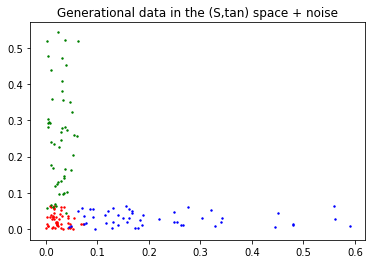

In [13]:
plt.scatter(np.absolute(patterns[i[0]:i[1],0]),np.absolute(patterns[i[0]:i[1],1]),c='r',s=2)
plt.scatter(np.absolute(patterns[i[1]:i[2],0]),np.absolute(patterns[i[1]:i[2],1]),c='b',s=2)
plt.scatter(np.absolute(patterns[i[2]:i[3],0]),np.absolute(patterns[i[2]:i[3],1]),c='g',s=2)
plt.title("Generational data in the (S,tan) space + noise")
plt.show()

Note that, in the previous setting, there was a clear separation between operational condition regions. Adding noise we introduce in-data confusion of states near the boundary between OC regions. As so, we are now going to monitor not only the training error, but also the test error and use it to decide the early stopping criterion.

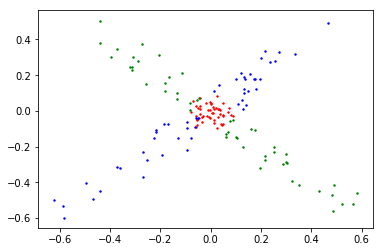

In [14]:
x = np.zeros([n,5])
for idi in range(len(patterns)):
    x[idi,0] = patterns[idi,0] + patterns[idi,1]
    x[idi,1] = patterns[idi,0] - patterns[idi,1]
    x[idi,2:] = patterns[idi,2:]
data = x[:,0:2]
target = x[:,2:] 
# Everyday I'm shuffling! Pew, pew, pew, pew, pew-pada
xshuf = x[np.random.permutation(n)]
datashuf = xshuf[:,0:2]
targetshuf = xshuf[:,2:]
plt.scatter(x[i[0]:i[1],0],x[i[0]:i[1],1],c='r',s=2)
plt.scatter(x[i[1]:i[2],0],x[i[1]:i[2],1],c='b',s=2)
plt.scatter(x[i[2]:i[3],0],x[i[2]:i[3],1],c='g',s=2)
plt.show()

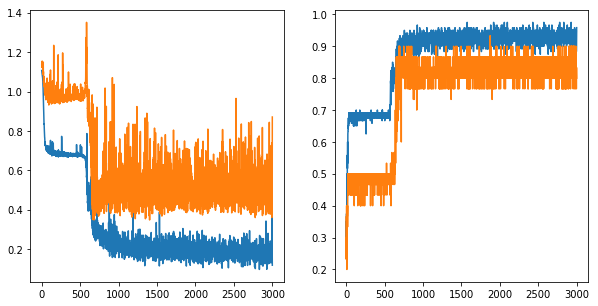

Error:  0.187258929809
Accuracy:  0.933333333333
Confusion C_(i,j) -> i: predicted, j: actual. 
[[45  1  4]
 [ 4 46  0]
 [ 1  0 49]]
Wall time: 9min 6s


In [15]:
%%time
np.random.seed(2379)
model = Sequential()
model.add(Dense(units=5, activation='tanh', input_dim=2,name="l4"))
model.add(Dense(units=3, activation='tanh',name="l3"))
model.add(Dense(units=2, activation='tanh',name="l2"))
model.add(Dense(units=2, activation='tanh',name="l1"))
model.add(Dense(units=3, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
callbacks = ModelCheckpoint('bestfit.hdf5',save_best_only=True)
# Training on the suffled data, 80-20 train-test split.
history = model.fit(datashuf, targetshuf, epochs=int(epocas), batch_size=1,verbose=0,callbacks=[callbacks],validation_split=0.2)
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax2.plot(history.history['acc'])
ax2.plot(history.history['val_acc'])
plt.show()
model = load_model('bestfit.hdf5')
evaluation = model.evaluate(data,target,verbose=0)
print("Error: ",evaluation[0])
print("Accuracy: ",evaluation[1])
y_pred = model.predict(data)
CM = confusion_matrix(np.argmax(target,axis=1),np.argmax(y_pred,axis=1))
print("Confusion C_(i,j) -> i: predicted, j: actual. ")
print(CM)


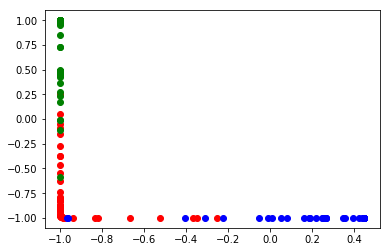

In [16]:
inter = Model(inputs=model.input, outputs=model.get_layer('l1').output)
interout = inter.predict(data)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(interout[i[0]:i[1],1],interout[i[0]:i[1],0],'ro',
         interout[i[1]:i[2],1],interout[i[1]:i[2],0],'bo',
         interout[i[2]:i[3],1],interout[i[2]:i[3],0],'go')
#ax1.set_title("l1")
plt.show()

As we can see, despite the presence of noise in the dataset, the model was able to train and test with an acceptable accuracy. The overall look in the LLS space is similar to the "L" shaped generational data. Comparing this plot to the one generated by the noiseless data, it becomes apparent a large confusion of states. As we can see in our confusion matrix, there are ten missclassified points. While some of it may relate to an lack of model fit, we cannot get rid of any confusion at all, since it appears as early as in the generation of the dataset.  Even so, this model demonstrated a high resilience to noise, or, otherwise, the overall look of the plot in the LLS would be distorted.

## Conclusion
Our toy wine factory's main concern is keeping the sweetness and tanins concentration product constant. Type 1 and 2 errors may represent two arbitrary failures in one or multiple components in the system. Sometimes, these are known process failures, but oftentimes, some failures are just complex or unknown a priori. For the instance, type 1 failure can be a fault on the mixer and type 2 yeast aging, which decreases the fermentation outputs.

This notebook visually indicates the powers of using a  deep architecture rather than a wide one, in order to solve process fault identification problems. Due to the simple nature of the problem, we were able to use a fully connected deep architecture. However, as problems get more complex, with more input variables, more patterns and time variations, we should consider using more advanced architectures such as convolutional neural networks, recurrent neural network or even concept learning.

The presence of an AI fault detector is of paramount importance to increase efficiency and decrease costs by keeping the plants downtime as low as possible. In the near future, this kind of tool is important to assist plant operators in troubleshooting, by decreasing FDD from days to seconds. As more and more failures are detected and reported, those data can be fed back to the neural networks, which may increase in complexity, and, as the virtuous cycle evolves, the machine learning fault detector can automate the vast majority of the diagnosis work.

The neural networks fault detector is another layer of automation on process industries, complementing the already present control loops, PLC supervisory systems and real time optimization schemes. As so, this could be nicely implemented on a separate screen, with a clean user interface and, ideally, with a conversational bot explaining the details of the fault. Therefore, having a good deep learning architecture supervising the process in real time is the core technology, which can have other deep learning plug-ins to increase its functionalities. With this setting, we can reduce costs and increase safety on any industrial processing plants.

## Future works
- Finding more complex problems to solve.
- Implementing partially connected networks for huge data volumes.
- Using DL for time series analysis on process variables.
- Reinforcement learning for real time optimization (RTO) using process simulators. 

## On humans, mathematicians and AIs
This work demonstrates two things: 
1. Without formal analytical comprehension of NNs, we can achieve excelet results, and as we, humans, acquire more understanding of the cognitive meaning of NN parameters, layers and architectures, we can hardwire our own knowledge, in the form of cues, to push further the cognitive capabilities of artificial intelligences. 
2. It's human plus AI. Ai is only competitive if we design it to be so. By cooperation with the machine we can achieve outstanding progress and alleviate suffering for humanity.

-----------THE END-----------